In [14]:
# [Humanized] Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


# [Humanized] Load datasets
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv') # [Humanized] Ensure test_df is loaded with all columns
sample_submission = pd.read_csv('/content/SampleSubmission.csv')

# [Humanized] Preview the data
print(train_df.head())
print(train_df.info())
print(train_df.describe())
print(train_df.isnull().sum())

   sl_no  gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1       0  67.00   Others  91.00   Others  Commerce     58.00   
1      2       0  79.33  Central  78.33   Others   Science     77.48   
2      3       0  65.00  Central  68.00  Central      Arts     64.00   
3      4       0  56.00  Central  52.00  Central   Science     52.00   
4      5       0  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80      Placed  270000.0  
1   Sci&Tech    Yes     86.5        Mkt&Fin  66.28      Placed  200000.0  
2  Comm&Mgmt     No     75.0        Mkt&Fin  57.80      Placed  250000.0  
3   Sci&Tech     No     66.0         Mkt&HR  59.43  Not Placed       NaN  
4  Comm&Mgmt     No     96.8        Mkt&Fin  55.50      Placed  425000.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column 

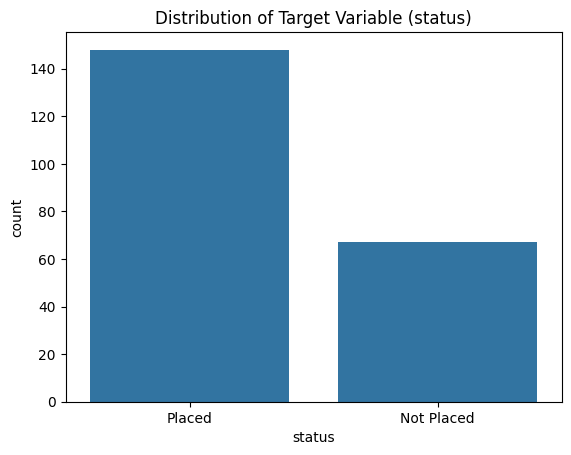

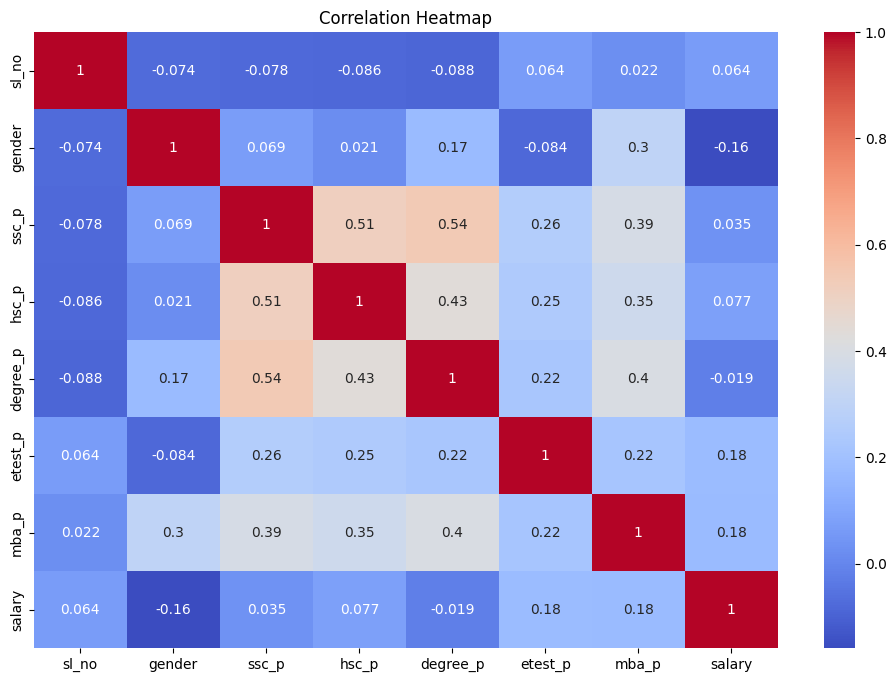

ssc_b: ['Others' 'Central']
hsc_b: ['Others' 'Central']
hsc_s: ['Commerce' 'Science' 'Arts']
degree_t: ['Sci&Tech' 'Comm&Mgmt' 'Others']
workex: ['No' 'Yes']
specialisation: ['Mkt&HR' 'Mkt&Fin']
status: ['Placed' 'Not Placed']


In [15]:
# [Humanized] Target variable distribution
sns.countplot(x='status', data=train_df)
plt.title('Distribution of Target Variable (status)')
plt.show()

# [Humanized] Correlation heatmap
plt.figure(figsize=(12, 8))
# [Humanized] Select only numeric columns for correlation calculation
numeric_train_df = train_df.select_dtypes(include=np.number)
sns.heatmap(numeric_train_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# [Humanized] Example: Checking categorical variables
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        print(f'{col}: {train_df[col].unique()}')

In [16]:
# [Humanized] Fill missing values if any
train_df.fillna(train_df.median(numeric_only=True), inplace=True)
test_df.fillna(test_df.median(numeric_only=True), inplace=True)


In [17]:
# [Humanized] Encoding categorical variables
le = LabelEncoder()

# [Humanized] Columns to encode in train_df and test_df (assuming test_df will eventually have these)
categorical_cols = ['ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']

for col in categorical_cols:
    if col in train_df.columns:
        train_df[col] = le.fit_transform(train_df[col])
    if col in test_df.columns: # [Humanized] Also encode if column exists in test_df
         test_df[col] = le.fit_transform(test_df[col])


# [Humanized] Encode target variable in train_df
train_df['status'] = train_df['status'].map({'Placed': 1, 'Not Placed': 0})

In [18]:
# [Humanized] Encoding categorical variables
le = LabelEncoder()

# [Humanized] Columns to encode in train_df and test_df (assuming test_df will eventually have these)
categorical_cols = ['ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']

for col in categorical_cols:
    if col in train_df.columns:
        train_df[col] = le.fit_transform(train_df[col])
    if col in test_df.columns: # [Humanized] Also encode if column exists in test_df
         test_df[col] = le.fit_transform(test_df[col])


# [Humanized] Encode target variable in train_df
train_df['status'] = train_df['status'].map({'Placed': 1, 'Not Placed': 0})

In [19]:
# [Humanized] Inspect the columns of the test dataset
temp_test_df = pd.read_csv('/content/test.csv')
print(temp_test_df.head())
print(temp_test_df.info())

   sl_no  gender         salary
0    123       1  236000.000000
1    199       1  288655.405405
2    138       0  225000.000000
3    137       1  288655.405405
4     76       1  288655.405405
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sl_no   43 non-null     int64  
 1   gender  43 non-null     int64  
 2   salary  43 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.1 KB
None


In [22]:
# [Humanized] Reload the original training data to ensure we start with the complete dataset
train_df = pd.read_csv('/content/train.csv')

# [Humanized] Drop rows with missing values in the target variable 'status'
train_df.dropna(subset=['status'], inplace=True)

# [Humanized] Re-apply preprocessing steps needed before splitting
# Assuming encoding was the primary preprocessing before split:
le = LabelEncoder()
categorical_cols = ['ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'workex', 'specialisation']
for col in categorical_cols:
    if col in train_df.columns:
        train_df[col] = le.fit_transform(train_df[col])

# [Humanized] Encode target variable in train_df
train_df['status'] = train_df['status'].map({'Placed': 1, 'Not Placed': 0})

# [Humanized] Create cleaned dataframe after preprocessing
cleaned_train_df = train_df.copy()

# [Humanized] Split features and target from the cleaned dataframe
X = cleaned_train_df.drop('status', axis=1)
y = cleaned_train_df['status']

# [Humanized] Train-Test split
X_train, X_valid, train_labels, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [23]:
# Split features and target
X = train_df.drop('status', axis=1)
y = train_df['status']

# Train-Test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [24]:
# [Humanized] Logistic Regression
log_reg = LogisticRegression(max_iter=1000)

# [Humanized] Random Forest
rf_clf = RandomForestClassifier(random_state=42)

# [Humanized] Support Vector Classifier
svc_clf = SVC(probability=True, random_state=42)


In [26]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train, train_labels)

# [Humanized] Best neural_net
best_rf = grid_search_rf.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [29]:
from sklearn.impute import SimpleImputer

# [Humanized] Impute missing values in X_train and X_valid
# Use the mean of each column from the training data
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on X_train and transform X_train and X_valid
X_train_imputed = imputer.fit_transform(X_train)
X_valid_imputed = imputer.transform(X_valid)

# Convert back to DataFrame to keep column names (optional but helpful)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
X_valid_imputed = pd.DataFrame(X_valid_imputed, columns=X_valid.columns, index=X_valid.index)


# Train models with imputed data
log_reg.fit(X_train_imputed, y_train)
best_rf.fit(X_train_imputed, y_train)
svc_clf.fit(X_train_imputed, y_train)

SVC(probability=True, random_state=42)

Logistic Regression:
Accuracy: 0.7231
Precision: 0.7647
Recall: 0.8667
F1 Score: 0.8125


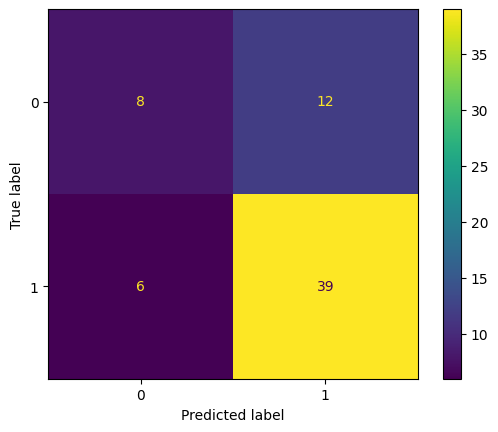

Random Forest:
Accuracy: 0.9846
Precision: 0.9783
Recall: 1.0000
F1 Score: 0.9890


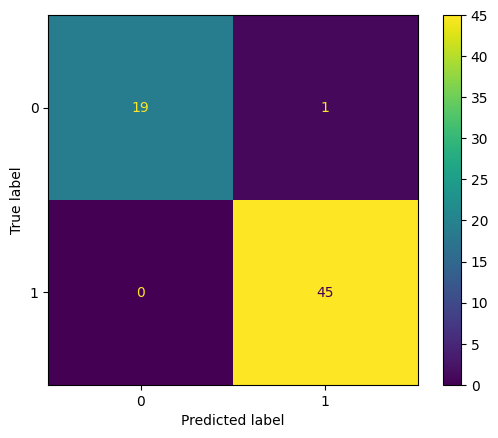

SVM:
Accuracy: 0.6923
Precision: 0.6923
Recall: 1.0000
F1 Score: 0.8182


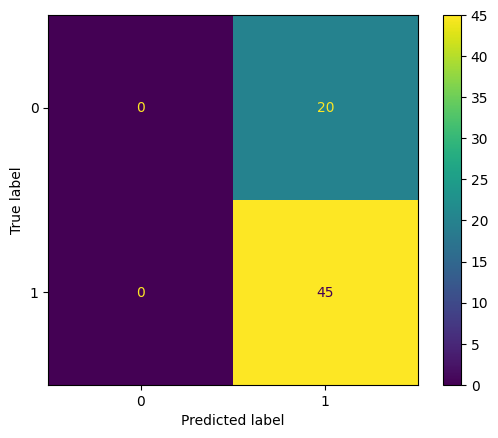

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, X_valid, y_valid):
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred)
    rec = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    cm = confusion_matrix(y_valid, y_pred)

    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

# [Humanized] Evaluate all models
print("Logistic Regression:")
evaluate_model(log_reg, X_valid_imputed, y_valid)

print("Random Forest:")
evaluate_model(best_rf, X_valid_imputed, y_valid)

print("SVM:")
evaluate_model(svc_clf, X_valid_imputed, y_valid)